# Лабораторная работа № 6 по дисциплине "Системы искусственного интеллекта"

# Задание лабораторной работы
0. Выбор датасета:
    - ~~Датасет о пассажирах Титаника: [Titanic Dataset](https://www.kaggle.com/c/titanic)~~
    - Датасет о диабете: [Diabetes Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
1. Загрузите выбранный датасет и выполните предварительную обработку данных. 
2. Получите и визуализируйте (графически) статистику по датасету (включая количество, среднее значение, стандартное отклонение, минимум, максимум и различные квантили).
3. Разделите данные на обучающий и тестовый наборы в соотношении, которое вы считаете подходящим.
4. Реализуйте логистическую регрессию "с нуля" без использования сторонних библиотек, кроме NumPy и Pandas. Ваша реализация логистической регрессии должна включать в себя:
    - Функцию для вычисления гипотезы (sigmoid function).
    - Функцию для вычисления функции потерь (log loss).
    - Метод обучения, который включает в себя градиентный спуск.
    - Возможность варьировать гиперпараметры, такие как коэффициент обучения (learning rate) и количество итераций.
5. Исследование гиперпараметров:
    - Проведите исследование влияния гиперпараметров на производительность модели. Варьируйте следующие гиперпараметры:
        - Коэффициент обучения (learning rate).
        - Количество итераций обучения.
        - Метод оптимизации (например, градиентный спуск или оптимизация Ньютона).
6. Оценка модели:
    - Для каждой комбинации гиперпараметров оцените производительность модели на тестовом наборе данных, используя метрики, такие как accuracy, precision, recall и F1-Score.

## Выполнение лабораторной работы
### 0. Установка и импорт библиотек, загрузка датасета

Сначала установим библиотеки, если они уже не установлены.

In [349]:
!pip install numpy pandas matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем необходимые библиотеки.

In [350]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from dataclasses import dataclass
import itertools

Выбираем датасет про диабет (т. к. датасет про Титаник не содержит значений целевой переменной в тестовом датасете)

Импортируем датасет:

In [351]:
df = pd.read_csv('../datasets/diabetes.csv')
print(df.describe(include='all'))
df.head()

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI    Pedigree         Age     Outcome  
count  768.000000  768.000000  768.000000  768.000000  
mean    31.992578    0.471876   33.240885    0.348958  
std      7.884160    0.331329   11.760232    0.476951  
min      0.000000    0.078000   21.000000    0.000000  
25%     27.300000    0.243750   24.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 1. Предварительная обработка данных

> Загрузите выбранный датасет и выполните предварительную обработку данных. 

#### ~~1.1. Удаление отсутствующих значений~~

Определим процент строк в тренировочном и тестовом датасете, содержащих отсутствующие значения:

In [352]:
def na_rate_dataframe(df: pd.DataFrame) -> float:
    return df.isna().any(axis='columns').sum() / df.shape[0]

def na_rate_series(s: pd.Series) -> float:
    return s.isna().sum() / s.size

print(f'Missing values in train dataset: {(na_rate_dataframe(df) * 100):.2f}%')
df.isna().sum()

Missing values in train dataset: 0.00%


Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
Pedigree         0
Age              0
Outcome          0
dtype: int64

Удаляем отсутствующие значения:

In [353]:
df = df.dropna(axis='columns')

#### 1.2. Разделение датасета на тренировочную и тестовую выборки
Возьмём 75% датасета в качестве тренировочного набора.

In [354]:
_TRAIN_PERCENTAGE = 0.75
_train_len = int(df.shape[0] * _TRAIN_PERCENTAGE)
df = df.sample(frac=1, random_state=267)
df_train = df[:_train_len]
df_test = df[_train_len:]

Для удобства переобозначим:

In [355]:
target_variable = 'Outcome'

x_train = df_train.drop(columns=[target_variable])
y_train = df_train[target_variable]
x_test = df_test.drop(columns=[target_variable])
y_test = df_test[target_variable]

#### 1.3. Импутация или удаление нулевых значений

Можно заметить, что в некоторых столбцах значительное количество значений 0 там, где они недопустимы (столбцы `Glucose`, `BloodPressure`, `SkinThickness`, `BMI`, `Glucose`). Предположительно, эти нули были вставлены вместо отсутствующих значений. Можно сделать одно из двух:
- удалить строки с нулевыми значениями
- **или** заменить нулевые значения на средние значения.

In [356]:
columns_to_fill = ['Insulin', 'BloodPressure', 'SkinThickness', 'BMI', 'Glucose']
delete_rows = False

if delete_rows:
    print(f'''Rows to delete: {
        (df[columns_to_fill] == 0).any(axis=1).sum()
    }''')
    df = df[(df[columns_to_fill] != 0).all(axis='columns')]
    
    _TRAIN_PERCENTAGE = 0.75
    _train_len = int(df.shape[0] * _TRAIN_PERCENTAGE)
    df = df.sample(frac=1, random_state=267)
    df_train = df[:_train_len]
    df_test = df[_train_len:]
else:
    _train_means = df_train[columns_to_fill].replace(0, pd.NA).mean()
    print(_train_means)
    df_train.loc[:, columns_to_fill] = \
        df_train[columns_to_fill].astype(float).replace(0, pd.NA).fillna(_train_means)
    
    df_test.loc[:, columns_to_fill] = \
        df_test[columns_to_fill].astype(float).replace(0, pd.NA).fillna(_train_means)

for col in columns_to_fill:
    print(f'{col}: {(df_train[col] == 0).sum()} zeroes in train, {(df_test[col] == 0).sum()} zeroes in test')

Insulin          158.676871
BloodPressure     72.268739
SkinThickness     29.208955
BMI                32.39174
Glucose          121.622378
dtype: object
Insulin: 0 zeroes in train, 0 zeroes in test
BloodPressure: 0 zeroes in train, 0 zeroes in test
SkinThickness: 0 zeroes in train, 0 zeroes in test
BMI: 0 zeroes in train, 0 zeroes in test
Glucose: 0 zeroes in train, 0 zeroes in test


C:\Users\vadim\AppData\Local\Temp\ipykernel_317148\2288249334.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[columns_to_fill].astype(float).replace(0, pd.NA).fillna(_train_means)
C:\Users\vadim\AppData\Local\Temp\ipykernel_317148\2288249334.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[160.         158.67687075 160.         158.67687075  75.
 240.         175.          74.         158.67687075 158.67687075
 171.         115.         125.         140.         125.
  18.         158.67687075 158.67687075 158.67687075 168.
 185.          36.         480.          55.         120.
 158.67687075  40.         158.67687075 158.67687075 158.67687075
  66.          94.          91.    

#### 1.4. Нормализация числовых признаков

Для числовых признаков выполним нормализацию по закону:
$$
x' = \cfrac{x-\bar x}{\sigma}.
$$

Значения выборочного среднего и стандартного отклонения берём из **тренировочного** датасета.

In [357]:
x_train_norm = x_train.copy()
x_test_norm = x_test.copy()

In [358]:
_x_mean = x_train.mean(axis=0)
_x_std = x_train.std(axis=0)
_x_std[_x_std == 0] = 1

In [359]:
x_train_norm = (x_train - _x_mean) / _x_std
x_test_norm = (x_test - _x_mean) / _x_std
x_train_norm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age
709,-0.532601,-0.863137,-0.232876,0.718084,0.684997,0.772591,0.673277,-0.845923
582,2.389094,0.006905,0.471253,-0.209307,-0.702186,-0.707737,-0.640349,2.465825
738,-0.532601,-0.676699,-0.434056,-0.209307,0.684997,0.592377,-0.026268,-1.015756
78,-1.116940,0.317634,-3.451753,-1.260351,-0.702186,1.441957,-0.605530,-0.591173
478,1.220416,0.162270,0.270073,1.089041,-0.051944,-0.784972,-0.947389,0.512743


#### 1.5. Кодирование категориальных признаков

Как можно видеть, здесь нет категориальных признаков, все числовые.

### 2. Визуализация данных

In [360]:
# Правило Стёрджиса для выбора оптимального количества интервалов в гистограмме 
def sturges(n):
    return int(1 + np.floor(np.log2(n)))

def visualize_numeric_columns(data):
    numeric_columns = data.select_dtypes(include='number').columns
    print(f'Numeric columns: {numeric_columns}')
    count = len(numeric_columns)
    num_rows = (count + 3 - 1) // 3
    
    desc = data.describe()
    
    fig = plt.figure(figsize=(min(15, count * 5), num_rows * 5))
    
    for i, col in enumerate(numeric_columns):
        ax = fig.add_subplot(num_rows, 3, i + 1)
        
        bin_count = min(sturges(len(data[col])), len(data[col].unique()))

        hist = ax.hist(data[col], bins=bin_count)

        count = int(desc[col]['count'])
        mean = desc[col]['mean']
        std = desc[col]['std']
        min_val = desc[col]['min']
        max_val = desc[col]['max']
        q25 = desc[col]['25%']
        median = desc[col]['50%']
        q75 = desc[col]['75%']
    
        line_mean = ax.plot([mean, mean], [0, np.max(hist[0])], color='green', label='Mean')
        line_mean_minus_std = ax.plot([mean - std, mean - std], [0, np.max(hist[0])],
                                      color='green', linestyle='dashed', label='Mean -/+ StD ')
        line_mean_plus_std = ax.plot([mean + std, mean + std], [0, np.max(hist[0])],
                                     color='green', linestyle='dashed')
        line_median = ax.plot([median, median], [0, np.max(hist[0])],
                              color='yellow', label='50% Quantile')
        line_q25 = ax.plot([q25, q25], [0, np.max(hist[0])],
                           color='yellow', linestyle='dashed', label='25% / 75% Quantile')
        line_q75 = ax.plot([q75, q75], [0, np.max(hist[0])],
                           color='yellow', linestyle='dashed')
        line_min = ax.plot([min_val, min_val], [0, np.max(hist[0])], color='red', label='Min / Max')
        line_max = ax.plot([max_val, max_val], [0, np.max(hist[0])], color='red')
    
        ax.set_title(
            f"""
    {col}
    count = {count}; min = {min_val:.6}; max = {max_val:.6};
    mean = {mean:.6}; std = {std:.6};
    q25 = {q25:.6}; median = {median:.6}; q75 = {q75:.6};
    """
        )
        ax.legend()
        ax.plot()

    fig.tight_layout()
    plt.show()
    
def visualize_categorical_columns(data):
    categorical_columns = data.select_dtypes(exclude='number').columns
    print(f'Categorical columns: {categorical_columns}')
    if len(categorical_columns) == 0:
        return
    
    count = len(categorical_columns)
    
    num_rows = (count + 3 - 1) // 3
    
    desc = data.describe()
    
    fig = plt.figure(figsize=(min(15, count * 5), num_rows * 5))
    for i, col in enumerate(categorical_columns):
        ax = fig.add_subplot(num_rows, 3, i + 1)
        sns.countplot(x=col, hue=col, data=data)
        
    fig.tight_layout()
    plt.show()
        

Визуализация тренировочного датасета (числовые признаки):

Numeric columns: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Pedigree', 'Age'],
      dtype='object')


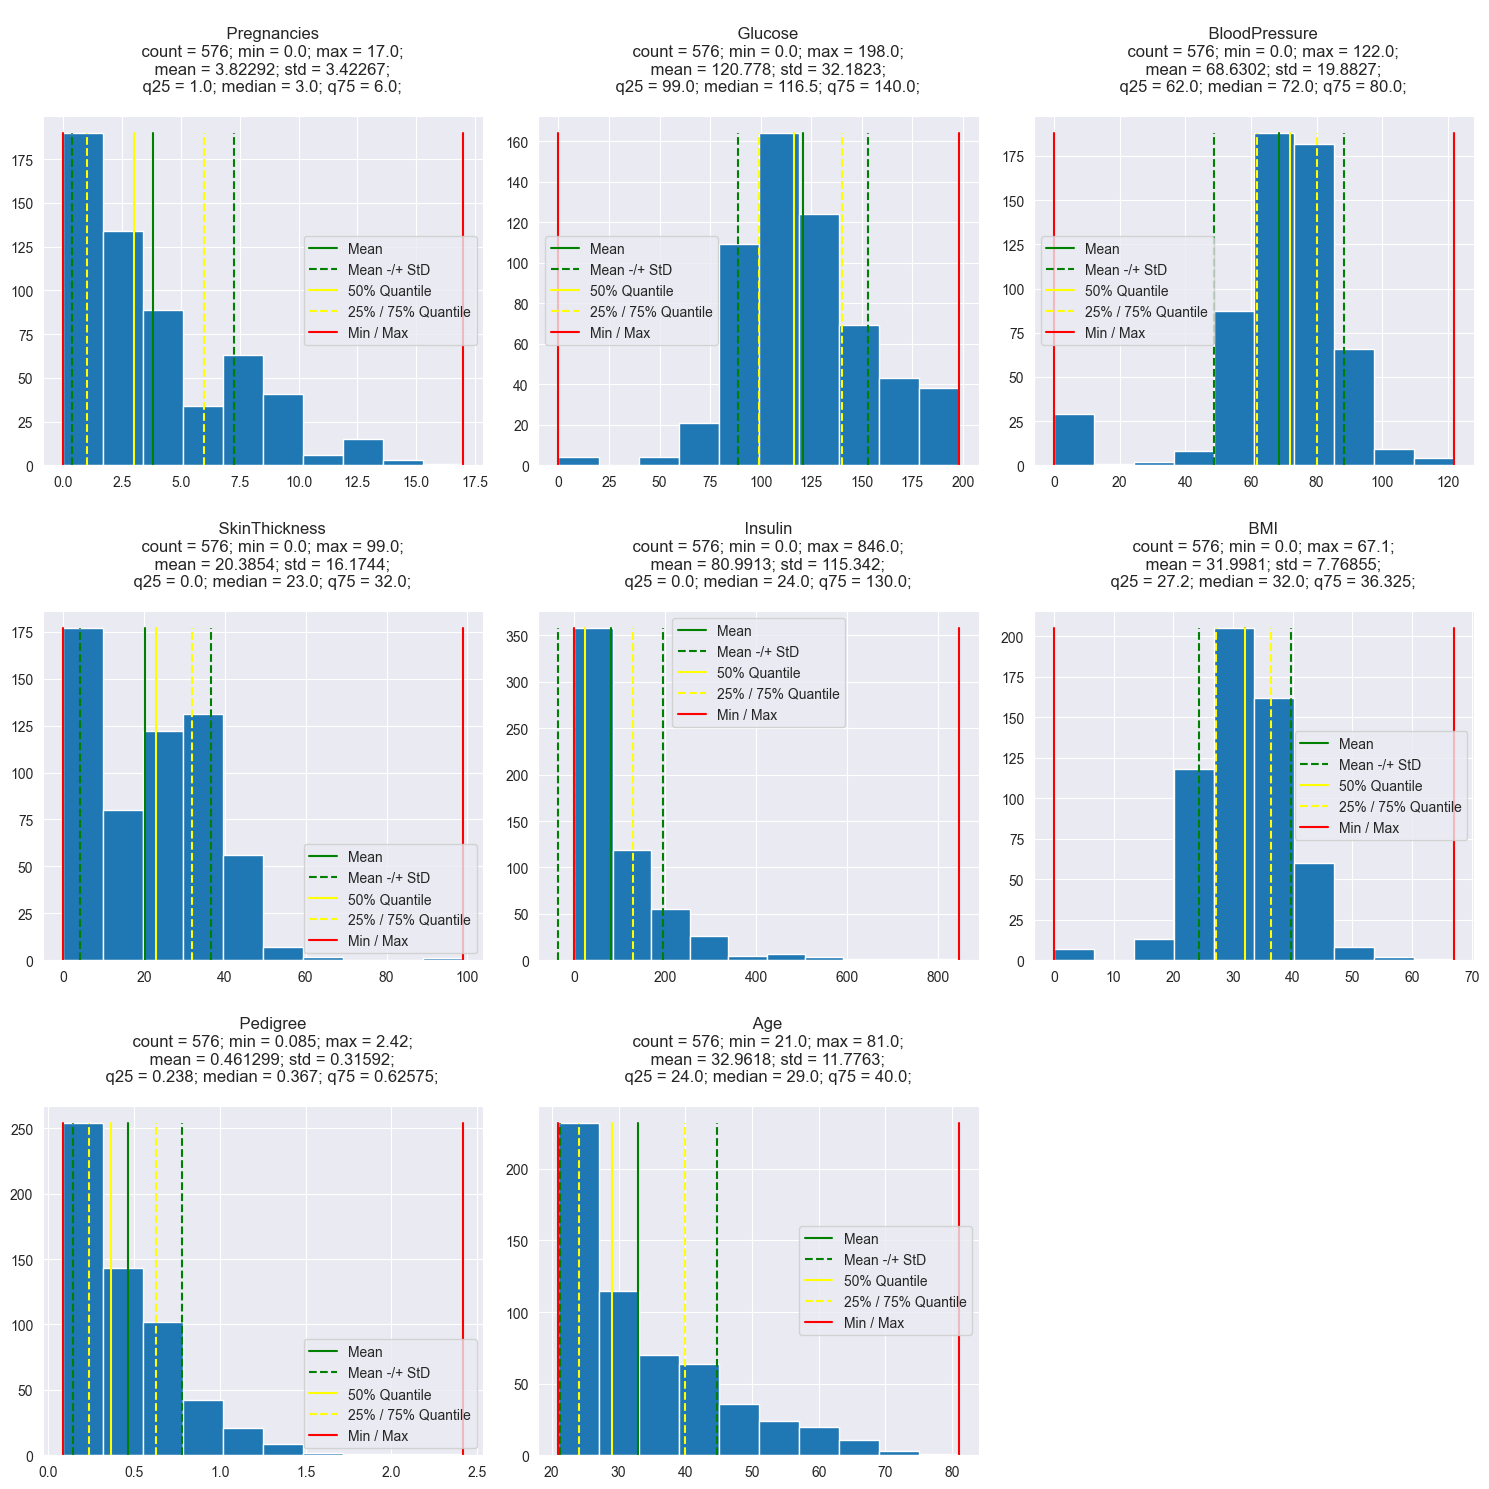

In [361]:
visualize_numeric_columns(x_train)

Визуализация тренировочного датасета (категориальные признаки):

In [362]:
visualize_categorical_columns(x_train)

Categorical columns: Index([], dtype='object')


Визуализация тестового датасета (числовые признаки):

Numeric columns: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Pedigree', 'Age'],
      dtype='object')


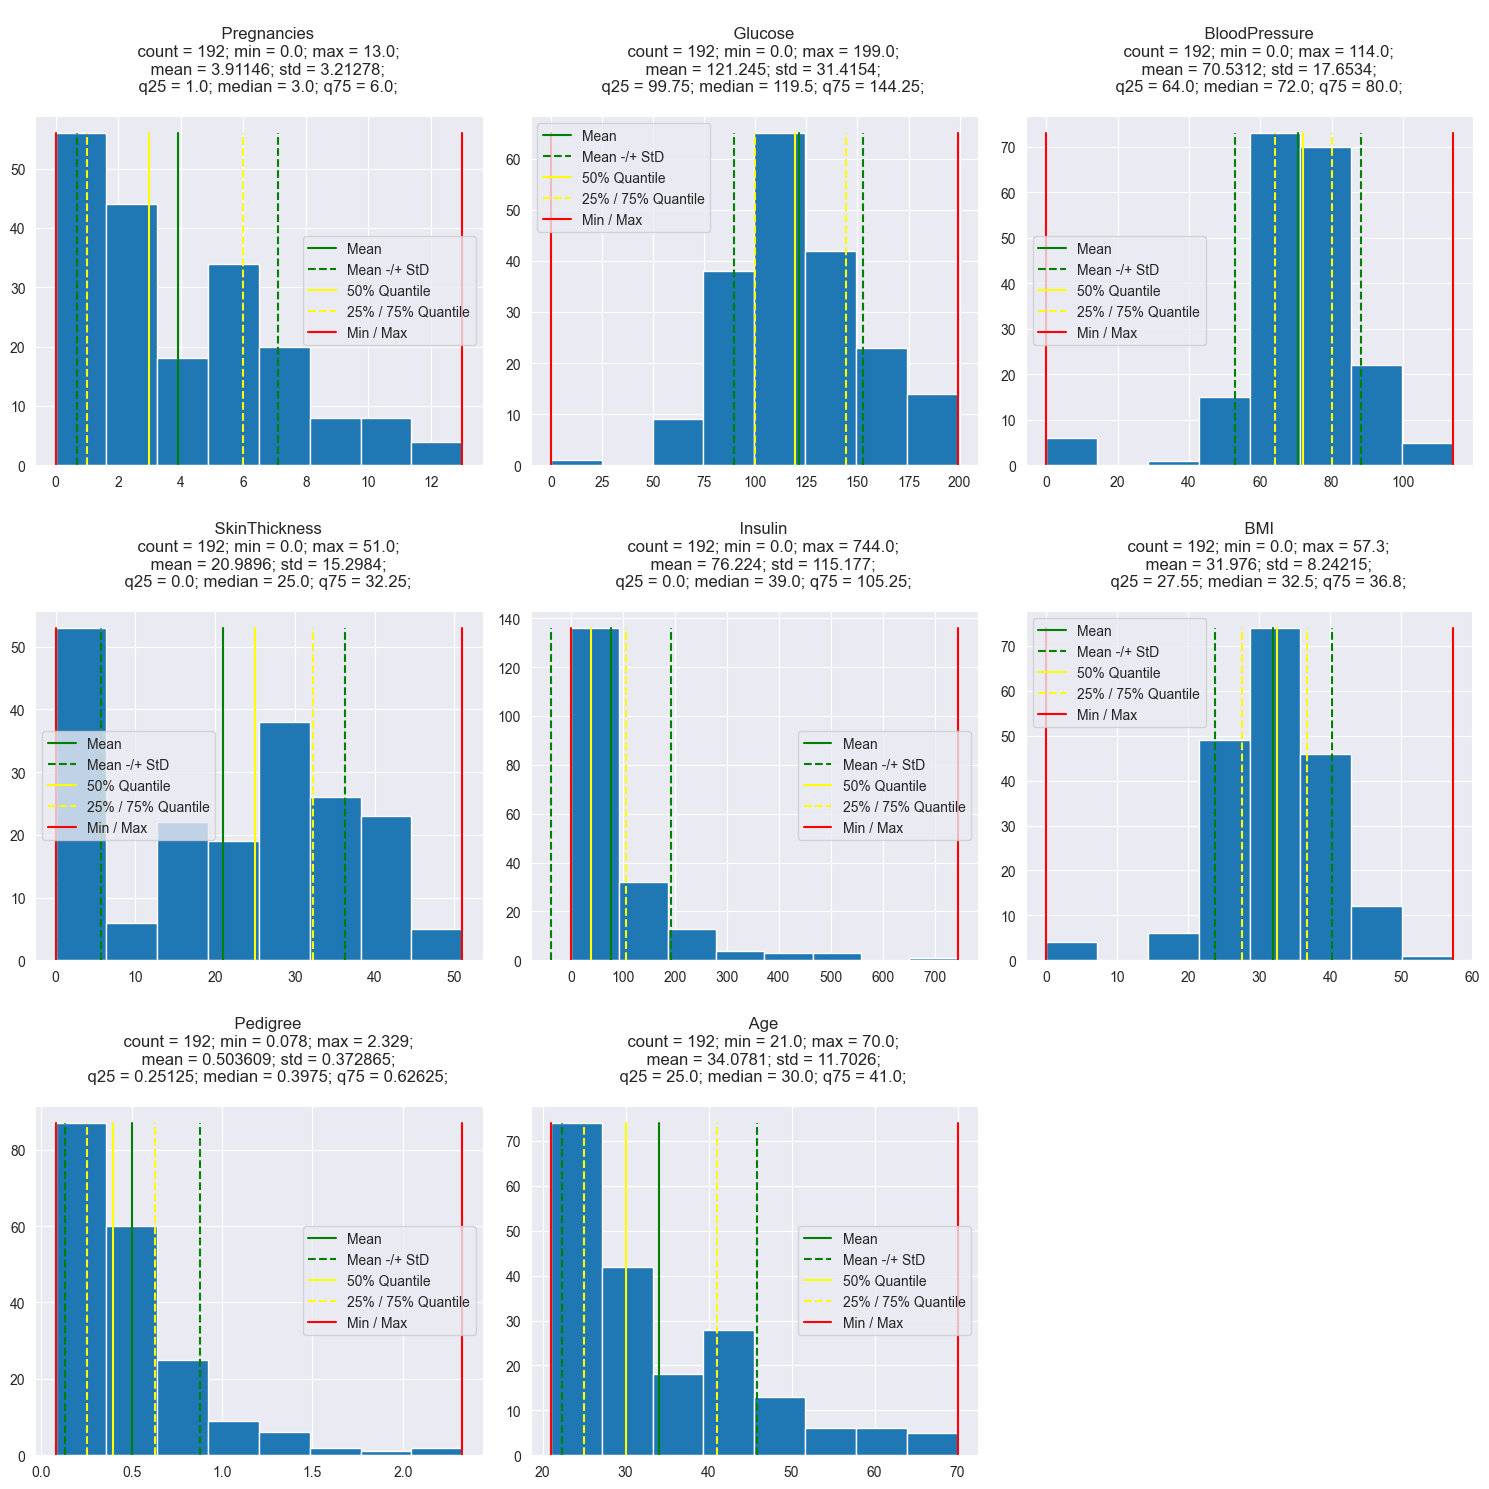

In [363]:
visualize_numeric_columns(x_test)

Визуализация тестового датасета (категориальные признаки):

In [364]:
visualize_categorical_columns(x_test)

Categorical columns: Index([], dtype='object')


Корреляция признаков в тренировочном датасете (нормализованном):

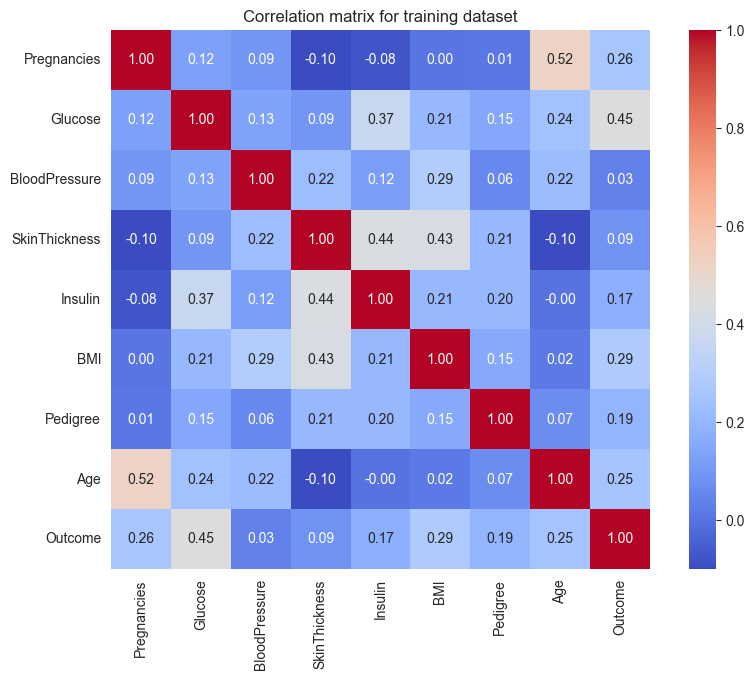

In [365]:
combined_train = pd.concat([x_train_norm, y_train], axis='columns')
corr_train = combined_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(
    corr_train,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar=True,
    square=True
)
plt.title('Correlation matrix for training dataset')
plt.show()

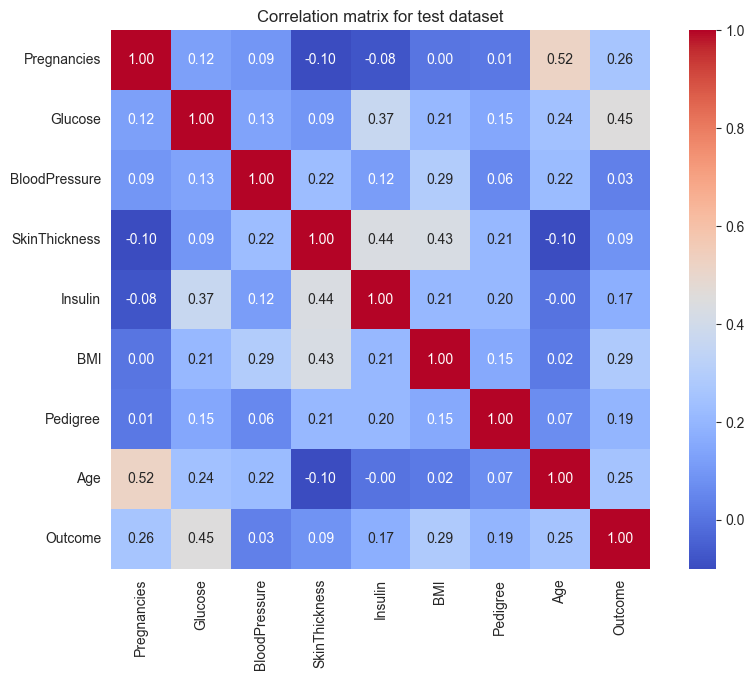

In [366]:
combined_test = pd.concat([x_test_norm, y_test], axis='columns')
corr_test = combined_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(
    corr_train,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar=True,
    square=True
)
plt.title('Correlation matrix for test dataset')
plt.show()

### 3. Разделение датасета на обучающий и тестовый наборы

Уже выполнено, т. к. тренировочный и тестовый наборы находятся в разных файлах.

Соотношение между числом строк в тренировочном и тестовом датасете:

In [367]:
_train_len = df_train.shape[0]
_test_len = df_test.shape[0]
_total_len = _train_len + _test_len

print(f'Train to test length ratio: {(_train_len / _total_len) * 100:.2f}% / {(_test_len / _total_len) * 100:.2f}%')

Train to test length ratio: 75.00% / 25.00%


### 4. Логистическая регрессия

#### 4.1. Сигмоида

Сигмоида -- это гладкая монотонная возрастающая нелинейная функция, имеющая форму буквы «S», которая часто применяется для «сглаживания» значений некоторой величины. Её часто используют для приведения произвольных значений к некоторому конечному интервалу.
$$
\sigma(t) = \cfrac{1}{1 + e^{-t}}
$$
$$
\sigma(0)=0.5;\;\lim\limits_{t\to -\infty}\sigma(t) = 0;\; \lim\limits_{t\to +\infty}\sigma(t) = 1.
$$

#### 4.2. Функция потерь

$$
\text{Cost}_i = \left\{
    \begin{matrix}
        \log\sigma(x_i), & y_i = 1 \\
        \log(1-\sigma(x_i)), & y_i = 0
    \end{matrix}
\right.
$$

Упрощённая функция потерь, без ветвления (т. к. $y_i$ может принимать значения только 0 и 1):

$$
\text{Cost}_i = y_i \log(\sigma(x_i)) + (1 - y_i) \log(1 - \sigma(x_i)).
$$

$$
L = -\frac{1}{m} \sum_{i=1}^m \left( y_i \log(\sigma(x_i)) + (1 - y_i) \log(1 - \sigma(x_i)) \right),
$$

где $m$ --- число элементов в тестовом датасете.

#### 4.3. Методы обучения

##### Градиентный спуск

Метод градиентного спуска -- метод оптимизации, который используется для поиска минимума функции (в нашем случае -- функции ошибок).

Основной принцип:
$$
\theta^{[j+1]} = \theta^{[j]} - \eta \cdot \nabla L(\theta^{[j]}),
$$
где $\theta$ -- параметры модели, $j > 0$ -- номер шага, $\eta$ -- размер шага обучения (learning rate), $L$ -- функция потерь.

Плюсы:
- Простой и гибкий.
- Расчёт градиента быстрее, чем расчёт гессиана.
- Меньше пространственная сложность.

Минусы:
- Медленная сходимость (особенно около минимума -- его легко перелететь).
- Может застрять в точках локального минимума.
- Требуется задавать размер шага.

##### Метод Ньютона

Метод Ньютона использует гессиан для минимизации функции потерь.

Основной принцип:
$$
\theta^{[j+1]} = \theta^{[j]} - H^{-1} \cdot \nabla L(\theta^{[j]}),
$$
где $\theta$ -- параметры модели, $j > 0$ -- номер шага, $H$ -- гессиан, $L$ -- функция потерь.

Плюсы:
- Быстрая сходимость (по количеству шагов).
- Не требуется задавать размер шага.
- Более точная информация о кривизне поверхности. 

Минусы:
- Высокая пространственная и временная сложность.

In [368]:
class LearningMethod(Enum):
    GRADIENT = 0
    NEWTON = 1

In [369]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, method=LearningMethod.GRADIENT, logging_interval=100):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.method = method
        self.logging_interval = logging_interval
        self.weights = None
        self.bias = 0

    @staticmethod
    def sigmoid(z):
        _THRESHOLD = 512
        z = np.clip(z, -_THRESHOLD, _THRESHOLD)
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def compute_loss(y_true, y_pred):
        epsilon = 1e-15  # To avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def gradient_descent_step(self, x, y):
        y_pred = self.sigmoid(np.dot(x, self.weights) + self.bias)
        dw = np.dot(x.T, (y_pred - y)) / len(y)
        db = np.sum(y_pred - y) / len(y)
        return dw, db

    def newton_step(self, x, y):
        m = x.shape[0]
        x_augmented = np.hstack((x, np.ones((m, 1)))) # Add a column of 1s to the left
        params = np.append(self.weights, self.bias)
        y_pred = self.sigmoid(np.dot(x_augmented, params))
        r = y_pred * (1 - y_pred)
        H = x_augmented.T @ (x_augmented * r[:, np.newaxis])
        grad = np.dot(x_augmented.T, (y_pred - y))
        try:
            delta = np.linalg.solve(H, grad)
        except np.linalg.LinAlgError:
            delta = np.linalg.pinv(H) @ grad
        # Update weights and bias
        self.weights -= delta[:-1]
        self.bias -= delta[-1]

    def fit(self, x, y):
        m, n = x.shape
        self.weights = np.zeros(n)
        self.bias = 0

        for i in range(self.num_iterations):
            if self.method == LearningMethod.GRADIENT:
                dw, db = self.gradient_descent_step(x, y)
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            elif self.method == LearningMethod.NEWTON:
                self.newton_step(x, y)
            else:
                raise ValueError(f"Unsupported method: {self.method}")

            if i % self.logging_interval == 0:
                y_pred = self.sigmoid(np.dot(x, self.weights) + self.bias)
                loss = self.compute_loss(y, y_pred)
                print(f"Iteration {i}, Loss: {loss}")

    def predict_proba(self, x):
        linear_model = np.dot(x, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, x, threshold=0.5):
        y_pred_proba = self.predict_proba(x)
        return (y_pred_proba >= threshold).astype(int)

    def __repr__(self):
        return f'LogisticRegression(learning_rate={self.learning_rate}, num_iterations={self.num_iterations}, method={self.method.name})'


Матрица ошибок:

In [370]:
@dataclass
class ConfusionMatrix:
    tp: int = 0  # True Positives
    tn: int = 0  # True Negatives
    fp: int = 0  # False Positives
    fn: int = 0  # False Negatives

    @classmethod
    def from_predictions(cls, y_true: np.ndarray, y_pred: np.ndarray) -> 'ConfusionMatrix':
        assert y_true.shape == y_pred.shape, "Shapes of y_true and y_pred must match"

        tp = np.sum((y_true == 1) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))

        return cls(tp=tp, tn=tn, fp=fp, fn=fn)

    def accuracy(self) -> float:
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    def precision(self) -> float:
        return self.tp / (self.tp + self.fp) if (self.tp + self.fp) > 0 else 0.0

    def recall(self) -> float:
        return self.tp / (self.tp + self.fn) if (self.tp + self.fn) > 0 else 0.0

    def f1_score(self) -> float:
        p = self.precision()
        r = self.recall()
        return 2 * p * r / (p + r) if (p + r) > 0 else 0.0

    def __repr__(self):
        return f"ConfusionMatrix(tp={self.tp}, tn={self.tn}, fp={self.fp}, fn={self.fn})"

Пример использования модели:

In [371]:
def _example_fit(_x_train, _x_test, _y_train, _y_test):
    model = LogisticRegression(logging_interval=50)
    model.fit(_x_train, _y_train)
    _y_pred = model.predict(_x_test)
    cm = ConfusionMatrix.from_predictions(_y_test, _y_pred)
    print(cm)
    print(f"F1: {cm.f1_score()}")

_example_fit(x_train_norm, x_test_norm, y_train, y_test)

Iteration 0, Loss: 0.6918129220677094
Iteration 50, Loss: 0.6373446013473747
Iteration 100, Loss: 0.6004188616103677
Iteration 150, Loss: 0.5743649721984733
Iteration 200, Loss: 0.5552562073340299
Iteration 250, Loss: 0.540763733313772
Iteration 300, Loss: 0.5294617443577659
Iteration 350, Loss: 0.5204435795406437
Iteration 400, Loss: 0.5131109033709528
Iteration 450, Loss: 0.5070551821159088
Iteration 500, Loss: 0.5019888488376497
Iteration 550, Loss: 0.49770394796302614
Iteration 600, Loss: 0.4940464693675985
Iteration 650, Loss: 0.4908999326836907
Iteration 700, Loss: 0.4881745942981448
Iteration 750, Loss: 0.4858001702437185
Iteration 800, Loss: 0.4837208156367196
Iteration 850, Loss: 0.48189158746017974
Iteration 900, Loss: 0.48027590410098653
Iteration 950, Loss: 0.4788436883699764
ConfusionMatrix(tp=40, tn=104, fp=22, fn=26)
F1: 0.625


### 5. Комбинации гиперпараметров
Создадим все возможные комбинации следующих значений гиперпараметров:
- Методы: `GRADIENT`, `NEWTON`
- Шаги: `0.001`, `0.005`, `0.01`, `0.05`, `0.1`, `0.5`, `1`
- Число итераций: `10`, `50`, `100`, `500`, `1000`, `5000`, `10000`
- Печатаем ошибку на текущей итерации через `max(1, num_iterations // 20)` итераций.

Сохраняем результат в списке словарей `results`. 

In [388]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
nums_iterations = [10, 50, 100, 500, 1000, 5000, 10000]
methods = [LearningMethod.NEWTON, LearningMethod.GRADIENT]

results = []

combs = itertools.product(learning_rates, nums_iterations, methods)

for comb in combs:
    learning_rate, num_iterations, method = comb
    model = LogisticRegression(
        learning_rate=learning_rate,
        num_iterations=num_iterations,
        method=method,
        logging_interval=max(1, num_iterations // 20)
    )
    print(model)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    cm = ConfusionMatrix.from_predictions(y_test, y_pred)
    
    results.append(
        {
            "f1": cm.f1_score(),
            "learning_rate": learning_rate,
            "num_iterations": num_iterations,
            "method": method,
            "accuracy": cm.accuracy(),
            "precision": cm.precision(),
            "recall": cm.recall(),
        }
    )
    
results_table = pd.DataFrame(results)
results_table.describe(include='all')

LogisticRegression(learning_rate=0.001, num_iterations=10, method=NEWTON)
Iteration 0, Loss: 0.4841486922423088
Iteration 1, Loss: 0.46615864910904015
Iteration 2, Loss: 0.4652738752129398
Iteration 3, Loss: 0.46527046535856353
Iteration 4, Loss: 0.4652704652996527
Iteration 5, Loss: 0.4652704652996527
Iteration 6, Loss: 0.4652704652996527
Iteration 7, Loss: 0.4652704652996527
Iteration 8, Loss: 0.4652704652996527
Iteration 9, Loss: 0.4652704652996527
LogisticRegression(learning_rate=0.001, num_iterations=10, method=GRADIENT)
Iteration 0, Loss: 1.0905955425752583
Iteration 1, Loss: 4.139239042503066
Iteration 2, Loss: 3.7476380518194596
Iteration 3, Loss: 1.5279916939856442
Iteration 4, Loss: 3.545266300387478
Iteration 5, Loss: 1.698665702400201
Iteration 6, Loss: 4.13779132707805
Iteration 7, Loss: 1.1117190430814512
Iteration 8, Loss: 3.073087878073715
Iteration 9, Loss: 2.247015119311203
LogisticRegression(learning_rate=0.001, num_iterations=50, method=NEWTON)
Iteration 0, Loss: 0.

,f1,learning_rate,num_iterations,method,accuracy,precision,recall
count,98.000000,98.000000,98.000000,98,98.000000,98.000000,98.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,LearningMethod.NEWTON,NaN,NaN,NaN
freq,NaN,NaN,NaN,49,NaN,NaN,NaN
mean,0.514495,0.238000,2380.000000,NaN,0.615274,0.501743,0.644867
std,0.189042,0.353563,3535.628963,NaN,0.171424,0.178344,0.290038
min,0.000000,0.001000,10.000000,NaN,0.338542,0.000000,0.000000
25%,0.506106,0.005000,50.000000,NaN,0.423177,0.345745,0.606061
50%,0.590608,0.050000,500.000000,NaN,0.708333,0.571970,0.606061
75%,0.634921,0.500000,5000.000000,NaN,0.760417,0.666667,0.954545


In [389]:
results_table = results_table.sort_values(by=['f1', 'accuracy', 'precision', 'recall', 'num_iterations', 'learning_rate'], kind='stable', ascending=False)
results_table.head()

,f1,learning_rate,num_iterations,method,accuracy,precision,recall
96,0.634921,1.00,10000,LearningMethod.NEWTON,0.760417,0.666667,0.606061
82,0.634921,0.50,10000,LearningMethod.NEWTON,0.760417,0.666667,0.606061
68,0.634921,0.10,10000,LearningMethod.NEWTON,0.760417,0.666667,0.606061
54,0.634921,0.05,10000,LearningMethod.NEWTON,0.760417,0.666667,0.606061
40,0.634921,0.01,10000,LearningMethod.NEWTON,0.760417,0.666667,0.606061


In [390]:
results_table.tail()

,f1,learning_rate,num_iterations,method,accuracy,precision,recall
73,0.055556,0.50,50,LearningMethod.GRADIENT,0.645833,0.333333,0.030303
97,0.028571,1.00,10000,LearningMethod.GRADIENT,0.645833,0.250000,0.015152
87,0.000000,1.00,50,LearningMethod.GRADIENT,0.656250,0.000000,0.000000
31,0.000000,0.01,50,LearningMethod.GRADIENT,0.656250,0.000000,0.000000
89,0.000000,1.00,100,LearningMethod.GRADIENT,0.645833,0.000000,0.000000


### 6. Анализ результатов

#### 6.1. Анализ результатов для разных методов

Общие статистики таблицы результатов (только метод градиентного спуска):

In [391]:
results_table[results_table['method'] == LearningMethod.GRADIENT].drop(columns=['method']).describe()

,f1,learning_rate,num_iterations,accuracy,precision,recall
count,49.000000,49.0000,49.00000,49.000000,49.000000,49.000000
mean,0.394069,0.2380,2380.00000,0.470132,0.336819,0.683673
std,0.206420,0.3554,3553.99599,0.127961,0.093503,0.408560
min,0.000000,0.0010,10.00000,0.338542,0.000000,0.000000
25%,0.381818,0.0050,50.00000,0.354167,0.340314,0.318182
50%,0.505837,0.0500,500.00000,0.421875,0.345745,0.954545
75%,0.516129,0.5000,5000.00000,0.645833,0.368421,0.984848
max,0.546296,1.0000,10000.00000,0.656250,0.477273,0.984848


Общие статистики таблицы результатов (только метод Ньютона):

In [376]:
results_table[results_table['method'] == LearningMethod.NEWTON].drop(columns=['method']).describe()

,f1,learning_rate,num_iterations,accuracy,precision,recall
count,25.000000,25.000000,25.000000,2.500000e+01,2.500000e+01,25.000000
mean,0.634921,0.322200,3222.000000,7.604167e-01,6.666667e-01,0.606061
std,0.000000,0.392916,3929.155974,1.133117e-16,1.133117e-16,0.000000
min,0.634921,0.001000,10.000000,7.604167e-01,6.666667e-01,0.606061
25%,0.634921,0.010000,100.000000,7.604167e-01,6.666667e-01,0.606061
50%,0.634921,0.100000,1000.000000,7.604167e-01,6.666667e-01,0.606061
75%,0.634921,0.500000,5000.000000,7.604167e-01,6.666667e-01,0.606061
max,0.634921,1.000000,10000.000000,7.604167e-01,6.666667e-01,0.606061


#### 6.2. Корреляционные матрицы

Построим матрицы корреляции между гиперпараметрами и метриками `accuracy`, `precision`, `recall`, `f1`:

Для метода градиентного спуска:

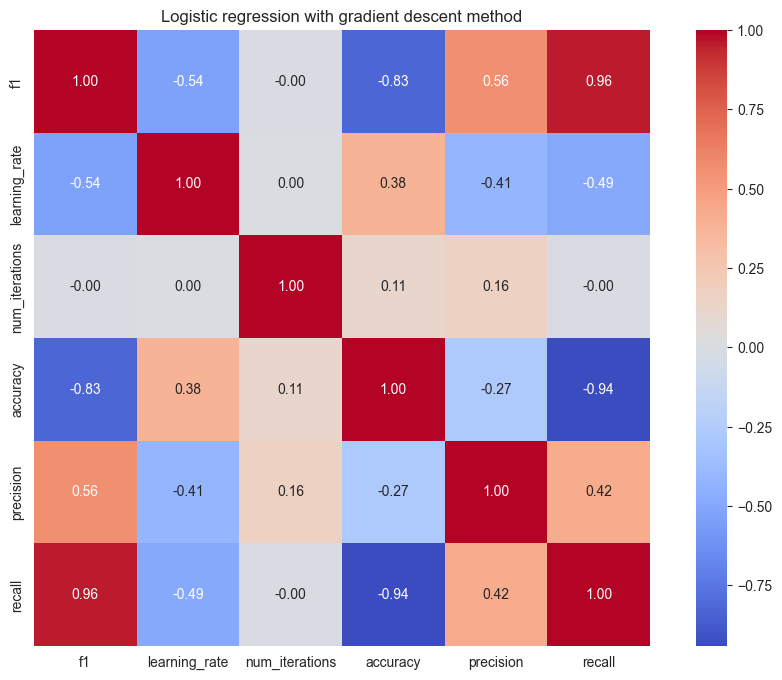

In [392]:
_results_gradient = results_table[results_table['method'] == LearningMethod.GRADIENT].drop(columns=['method'])
_corr_results_gradient = _results_gradient.corr()
plt.figure(figsize=(12,8))
sns.heatmap(
    _corr_results_gradient,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar=True,
    square=True
)
plt.title('Logistic regression with gradient descent method')
plt.show()

Для метода градиентного спуска:
- Видим, что количество итераций незначительно влияет на точность модели (-0.00). Возможные причины: 
    - Если градиентный спуск быстро достигает оптимальной точки, то дальнейшие итерации уже не приносят заметного прироста в точности.
    - Может иметь место переобучение. 
- Видим, что learning_rate отрицательно влияет на точность модели (-0.54). Возможные причины:
    - Из-за слишком большого шага веса "перелетают" через точку минимума функции потерь. Это приводит к тому, что нужная точность так и не достигается.
    - Для некоторых конфигураций (особенно с большим learning_rate и малым количеством итераций) веса могут становиться слишком большими, что приводит к невозможности обучения.
    - При высоком learning_rate даже большого количества итераций может быть недостаточно, чтобы компенсировать ошибки, накопленные из-за больших шагов. 

Для метода Ньютона:

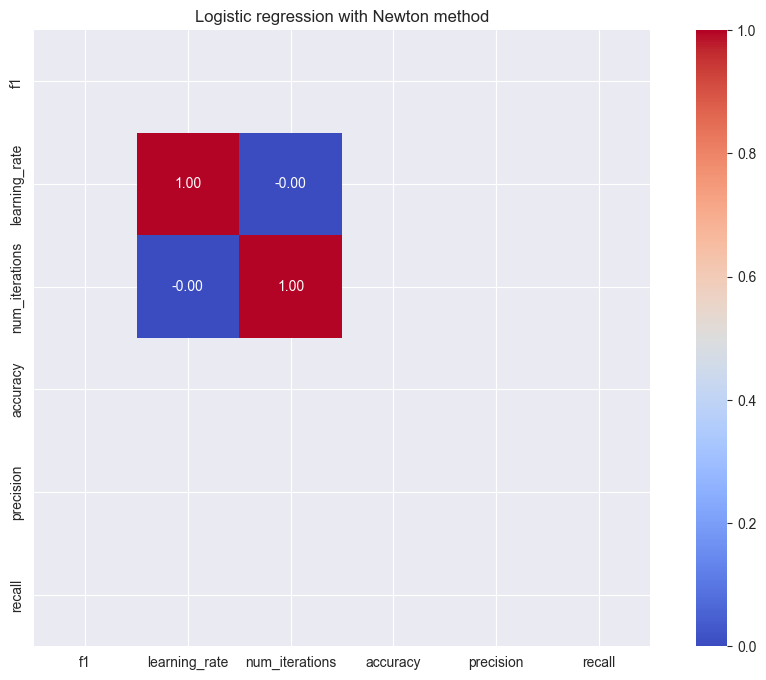

In [393]:
_results_newton = results_table[results_table['method'] == LearningMethod.NEWTON].drop(columns=['method'])
_corr_results_newton = _results_newton.corr()
plt.figure(figsize=(12,8))
sns.heatmap(
    _corr_results_newton,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar=True,
    square=True
)
plt.title('Logistic regression with Newton method')
plt.show()

Результаты в случае с методом Ньютона обусловлены следующим:
- Метод Ньютона очень быстро сходится. Поэтому уже после первых нескольких шагов (по-видимому, даже после первого) функция потерь не убывает либо убывает незначительно.
- Так как веса не меняются, предсказания остаются одинаковыми, и, соответственно, `precision`, `recall`, `accuracy`, `F1` -- не меняются. 

#### 6.3. Графики зависимостей от параметров модели

method LearningMethod.NEWTON
	 learning_rate 0.001
	 learning_rate 0.005
	 learning_rate 0.01
	 learning_rate 0.05
	 learning_rate 0.1
	 learning_rate 0.5
	 learning_rate 1.0
method LearningMethod.GRADIENT
	 learning_rate 0.001
	 learning_rate 0.005
	 learning_rate 0.01
	 learning_rate 0.05
	 learning_rate 0.1
	 learning_rate 0.5
	 learning_rate 1.0


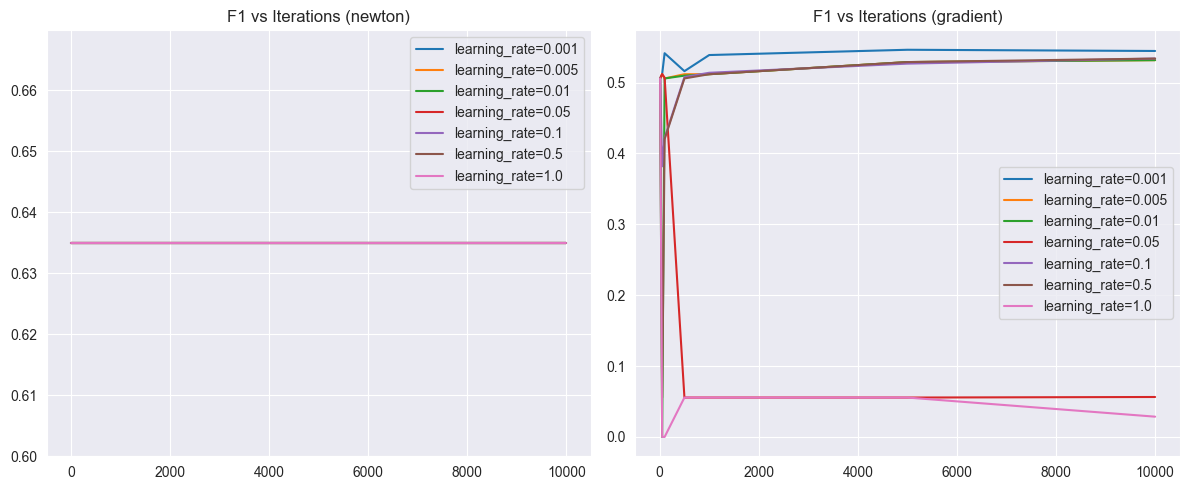

method LearningMethod.NEWTON
	 learning_rate 0.001
	 learning_rate 0.005
	 learning_rate 0.01
	 learning_rate 0.05
	 learning_rate 0.1
	 learning_rate 0.5
	 learning_rate 1.0
method LearningMethod.GRADIENT
	 learning_rate 0.001
	 learning_rate 0.005
	 learning_rate 0.01
	 learning_rate 0.05
	 learning_rate 0.1
	 learning_rate 0.5
	 learning_rate 1.0


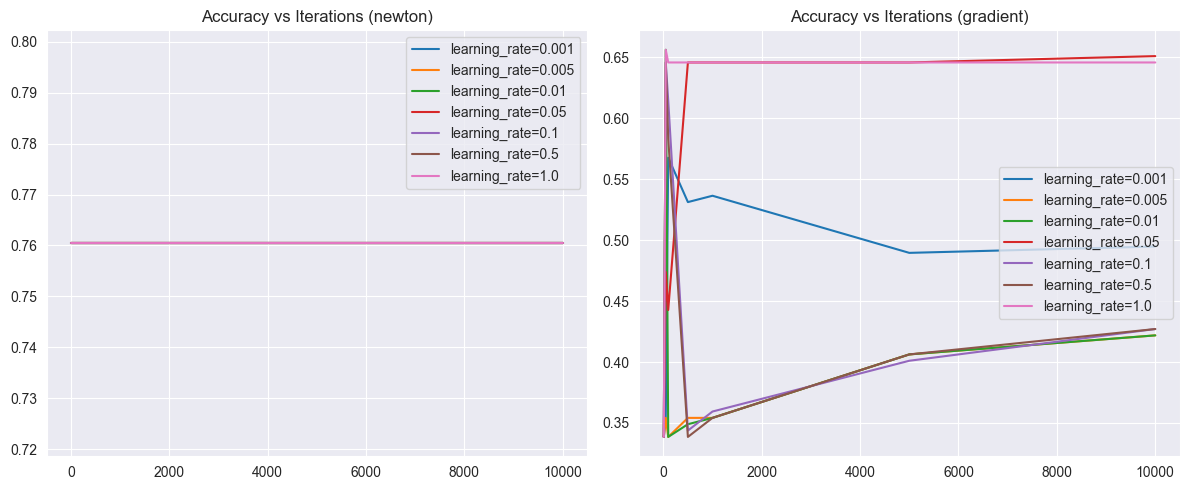

method LearningMethod.NEWTON
	 learning_rate 0.001
	 learning_rate 0.005
	 learning_rate 0.01
	 learning_rate 0.05
	 learning_rate 0.1
	 learning_rate 0.5
	 learning_rate 1.0
method LearningMethod.GRADIENT
	 learning_rate 0.001
	 learning_rate 0.005
	 learning_rate 0.01
	 learning_rate 0.05
	 learning_rate 0.1
	 learning_rate 0.5
	 learning_rate 1.0


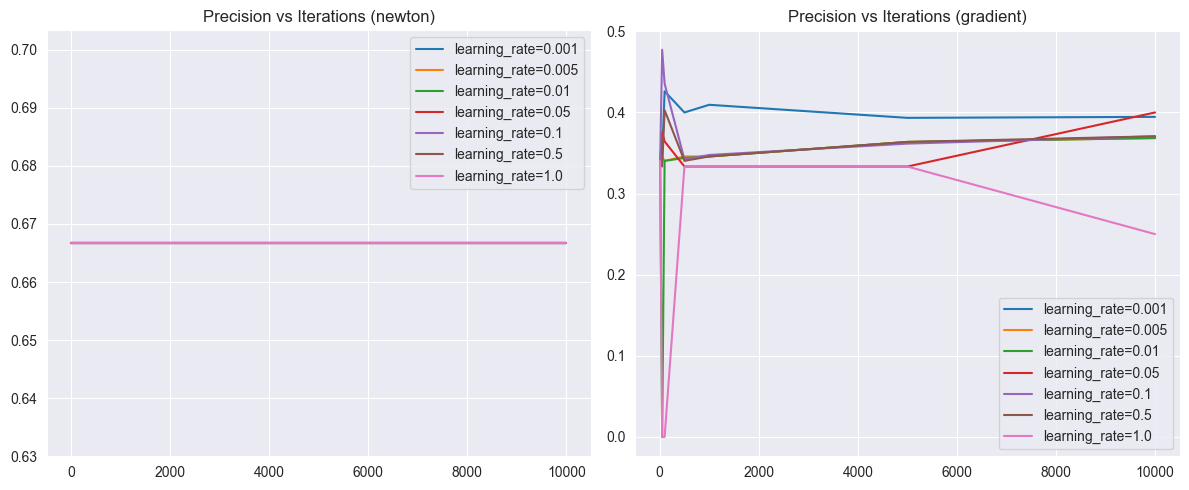

method LearningMethod.NEWTON
	 learning_rate 0.001
	 learning_rate 0.005
	 learning_rate 0.01
	 learning_rate 0.05
	 learning_rate 0.1
	 learning_rate 0.5
	 learning_rate 1.0
method LearningMethod.GRADIENT
	 learning_rate 0.001
	 learning_rate 0.005
	 learning_rate 0.01
	 learning_rate 0.05
	 learning_rate 0.1
	 learning_rate 0.5
	 learning_rate 1.0


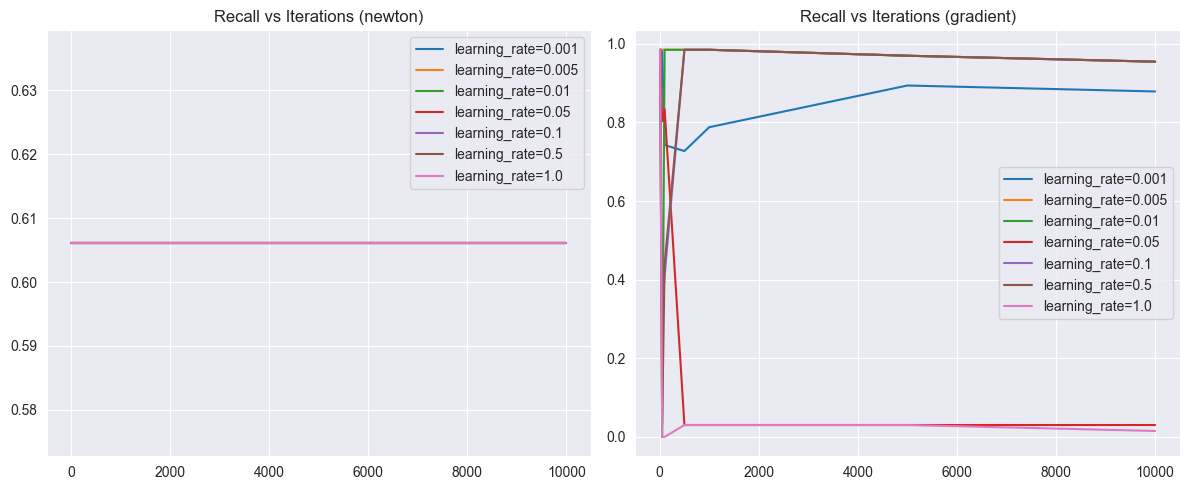

In [400]:
# Assuming `results_table` contains the necessary data
def plot_metric_vs_iterations(results_table, metric, varying_param, methods, method_column='method'):
    fig = plt.figure(figsize=(12, 5))
    
    for i, method in enumerate(methods):
        filtered_data = results_table[results_table[method_column] == method]
        ax = fig.add_subplot(1, len(methods), i+1)

        print('method', method)
        for param_value in sorted(filtered_data[varying_param].unique()):
            param_filtered_data = (
                filtered_data[filtered_data[varying_param] == param_value]
                .sort_values(by='num_iterations', ascending=False)
            )
            print('\t', varying_param, param_value)
            ax.plot(
                param_filtered_data['num_iterations'],
                param_filtered_data[metric],
                label=f"{varying_param}={param_value}"
            )

        ax.set_title(f"{metric.capitalize()} vs Iterations ({method.name.lower()})")
        # ax.xlabel("Iterations")
        # ax.ylabel(metric.capitalize())
        ax.legend()
        ax.grid(True)
    
    fig.tight_layout()
    plt.show()

for metric in ['f1', 'accuracy', 'precision', 'recall']:
    # Plotting precision vs iteration count for different learning rates and methods
    plot_metric_vs_iterations(
        results_table,
        metric=metric,
        varying_param="learning_rate",
        methods=results_table['method'].unique()
    )

#### 6.4. Выбор наилучшей модели

In [406]:
results_table = (results_table
    .sort_values(by=['learning_rate', 'num_iterations'])
    .sort_values(by=['f1', 'accuracy', 'precision', 'recall'], kind='stable', ascending=False)
)

best_model = results_table.iloc[0]
print(f'''
Best model:
    Learning rate: {best_model.learning_rate}
    Number of iterations: {best_model.num_iterations}
    Method: {best_model.method.name.lower()}
    F1: {best_model.f1:.6f}
    Accuracy: {best_model.accuracy:.6f}
    Precision: {best_model.precision:.6f}
    Recall: {best_model.recall:.6f}
''')


Best model:
    Learning rate: 0.001
    Number of iterations: 10
    Method: newton
    F1: 0.634921
    Accuracy: 0.760417
    Precision: 0.666667
    Recall: 0.606061

